# Description

This notebooks analyzes CCC in the presence of data with substructures. The analyses are focused on the Reviewer 2's comment:

```
Consider a scenario where there are two distinct clusters in the data. If the data has a clear cluster, the CCC will always be 1. This may not be an expected result, especially if we know there are substructures in the data, such as different cell types. Will the CCC method fail in such datasets?
```

# Modules

In [1]:
import pandas as pd

from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import make_blobs

from ccc import conf
from ccc.coef import ccc
from ccc.methods import mic

# Settings

In [2]:
RANDOM_STATE = 123

# Paths

In [3]:
OUTPUT_FIGURE_DIR = conf.MANUSCRIPT["FIGURES_DIR"] / "misc" / "data_with_substructures"
OUTPUT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_FIGURE_DIR)

PosixPath('/opt/manuscript/content/images/misc/data_with_substructures')

# Diagonal

In [4]:
n_samples = 5000

centers = [(-2.5, -2.5), (2.5, 2.5)]
X, y = make_blobs(
    n_samples=n_samples, centers=centers, shuffle=True, random_state=RANDOM_STATE
)

In [5]:
data = pd.DataFrame(X).rename(columns={0: "x", 1: "y"})
data = data.assign(dataset="Diagonal")

In [6]:
data.shape

(5000, 3)

In [7]:
data.head()

,x,y,dataset
0,1.671352,1.727129,Diagonal
1,2.618061,2.598650,Diagonal
2,4.620568,2.467530,Diagonal
3,3.648556,0.014375,Diagonal
4,-5.340847,-2.656083,Diagonal


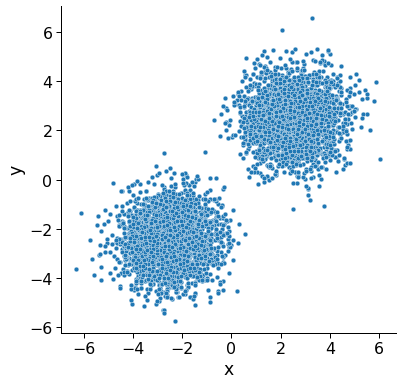

In [8]:
with sns.plotting_context("paper", font_scale=1.8):
    plt.subplots(figsize=(6, 6))
    sns.scatterplot(data=data, x="x", y="y")
    plt.axis("equal")
    sns.despine()

In [9]:
datasets_df = data

# Horizontal

In [10]:
n_samples = 5000

centers = [(-2.5, 0), (2.5, 0)]
X, y = make_blobs(
    n_samples=n_samples, centers=centers, shuffle=True, random_state=RANDOM_STATE
)

In [11]:
data = pd.DataFrame(X).rename(columns={0: "x", 1: "y"})
data = data.assign(dataset="Horizontal")

In [12]:
data.shape

(5000, 3)

In [13]:
data.head()

,x,y,dataset
0,1.671352,-0.772871,Horizontal
1,2.618061,0.098650,Horizontal
2,4.620568,-0.032470,Horizontal
3,3.648556,-2.485625,Horizontal
4,-5.340847,-0.156083,Horizontal


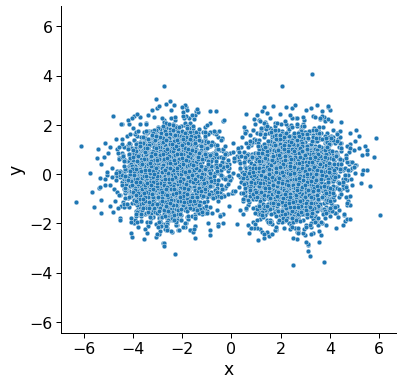

In [14]:
with sns.plotting_context("paper", font_scale=1.8):
    plt.subplots(figsize=(6, 6))
    sns.scatterplot(data=data, x="x", y="y")
    plt.axis("equal")
    sns.despine()

In [15]:
datasets_df = datasets_df.append(
    data,
    ignore_index=True,
)

# Vertical

In [16]:
n_samples = 5000

centers = [(0, -2.5), (0, 2.5)]
X, y = make_blobs(
    n_samples=n_samples, centers=centers, shuffle=True, random_state=RANDOM_STATE
)

In [17]:
data = pd.DataFrame(X).rename(columns={0: "x", 1: "y"})
data = data.assign(dataset="Vertical")

In [18]:
data.shape

(5000, 3)

In [19]:
data.head()

,x,y,dataset
0,-0.828648,1.727129,Vertical
1,0.118061,2.598650,Vertical
2,2.120568,2.467530,Vertical
3,1.148556,0.014375,Vertical
4,-2.840847,-2.656083,Vertical


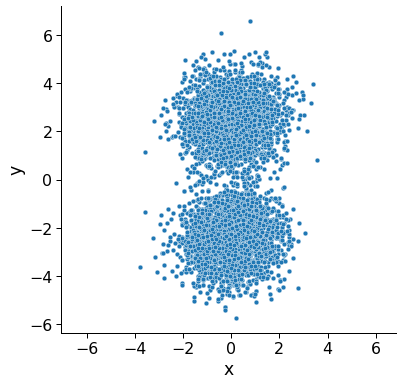

In [20]:
with sns.plotting_context("paper", font_scale=1.8):
    plt.subplots(figsize=(6, 6))
    sns.scatterplot(data=data, x="x", y="y")
    plt.axis("equal")
    sns.despine()

In [21]:
datasets_df = datasets_df.append(
    data,
    ignore_index=True,
)

# Understand how CCC divides samples

## Prepare datasets

In [22]:
datasets = {
    idx: df.drop(columns="dataset") for idx, df in datasets_df.groupby("dataset")
}

## Plot

In [23]:
def get_cm_line_points(x, y, max_parts, parts):
    """
    Given two data vectors (x and y) and the max_parts and parts
    returned from calling cm, this function returns two arrays with
    scalars to draw the lines that separates clusters in x and y.
    """
    # get the ccc partitions that maximize the coefficient
    x_max_part = parts[0][max_parts[0]]
    x_unique_k = {}
    for k in np.unique(x_max_part):
        data = x[x_max_part == k]
        x_unique_k[k] = data.min(), data.max()
    x_unique_k = sorted(x_unique_k.items(), key=lambda x: x[1][0])

    y_max_part = parts[1][max_parts[1]]
    y_unique_k = {}
    for k in np.unique(y_max_part):
        data = y[y_max_part == k]
        y_unique_k[k] = data.min(), data.max()
    y_unique_k = sorted(y_unique_k.items(), key=lambda x: x[1][0])

    x_line_points, y_line_points = [], []

    for idx in range(len(x_unique_k) - 1):
        k, (k_min, k_max) = x_unique_k[idx]
        nk, (nk_min, nk_max) = x_unique_k[idx + 1]

        x_line_points.append((k_max + nk_min) / 2.0)

    for idx in range(len(y_unique_k) - 1):
        k, (k_min, k_max) = y_unique_k[idx]
        nk, (nk_min, nk_max) = y_unique_k[idx + 1]

        y_line_points.append((k_max + nk_min) / 2.0)

    return x_line_points, y_line_points

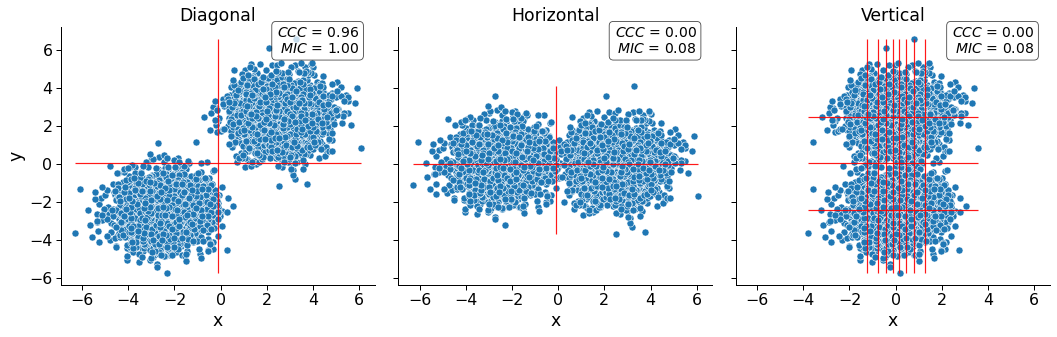

In [24]:
with sns.plotting_context("paper", font_scale=1.8):
    g = sns.FacetGrid(
        data=datasets_df,
        col="dataset",
        col_order=[
            "Diagonal",
            "Horizontal",
            "Vertical",
        ],
        col_wrap=3,
        height=5,
    )
    g.map(sns.scatterplot, "x", "y", s=50, alpha=1)
    g.set_titles(row_template="{row_name}", col_template="{col_name}")

    for ds, ax in g.axes_dict.items():
        df = datasets[ds].to_numpy()
        x, y = df[:, 0], df[:, 1]

        # pearson and spearman
        r = pearsonr(x, y)[0]
        rs = spearmanr(x, y)[0]

        # ccc
        c, max_parts, parts = ccc(x, y, return_parts=True)
        c = ccc(x, y)
        m = mic(x, y)

        x_line_points, y_line_points = get_cm_line_points(x, y, max_parts, parts)
        for yp in y_line_points:
            ax.hlines(y=yp, xmin=x.min(), xmax=x.max(), color="r", alpha=0.90)

        for xp in x_line_points:
            ax.vlines(x=xp, ymin=y.min(), ymax=y.max(), color="r", alpha=0.90)

        # add text box for the statistics
        stats = f"$CCC$ = {c:.2f}\n $MIC$ = {m:.2f}"
        bbox = dict(boxstyle="round", fc="white", ec="black", alpha=0.75)
        ax.text(
            0.95,
            0.90,
            stats,
            fontsize=14,
            bbox=bbox,
            transform=ax.transAxes,
            horizontalalignment="right",
        )

    plt.savefig(
        OUTPUT_FIGURE_DIR / "clusters.png",
        # rasterized=True,
        dpi=300,
        bbox_inches="tight",
        facecolor="white",
    )